In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import *

# Back to the basics: Multilayer Perceptron

Bei der Klassifikation von Bildern können wir mit CNN und einer Menge kleiner Tricks und Best Practices sehr gute Ergebnisse erreichen. Aber wie funktioniert die Klassifikation, wenn wir nicht in die Trick-Kiste greifen? 

## Ein Klassiker unter den Datensätzen: MNIST

Wir starten mit einem "einfachen" Datensatz, der auch ohne Tricks beherrschbar ist. Der MNIST-Datensatz enthält ein Sammlung von handgeschriebenen Ziffern. Die Daten sind bereits in einen Traininsdatensatz und einen Validierungsdatensatz aufgeteilt.

### Datenaufbereitung

In [3]:
MNIST_path = untar_data(URLs.MNIST)
MNIST_path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/testing'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/models')]

Die Ziffern liegen jeweils in einem eigenen Ordner

In [4]:
(MNIST_path / 'training').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5')]

Wir laden mit einer Minibatch-Größe von 64...

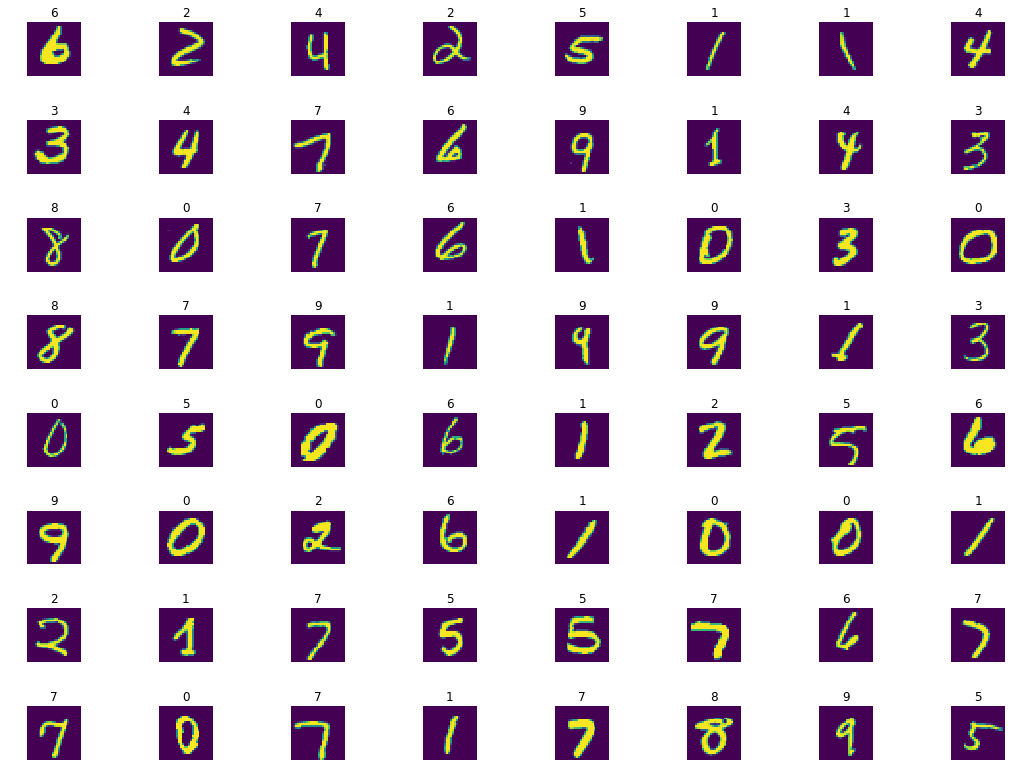

In [72]:
data = (ImageList.from_folder(MNIST_path, convert_mode='L') # convert_mode='L' erzeugt einen Channel (und nicht drei für RGB)
        .split_by_folder(train='training', valid='testing')
        .label_from_folder()
        .transform(size=28)
        .databunch(bs=64))
data.show_batch(rows=8, figsize=(15,11))

Wir haben 60.000 Beispiele in unserem Trainingsdatensatz.

In [77]:
len(data.train_ds)

60000

Die Validierung erfolgt mit 10.000 Beispielen.

In [79]:
len(data.valid_ds)

10000

Die Anzahl der Beispiele pro Klasse sind im Trainings- und Testdatensatz einigermaßen ausbalanciert...

In [94]:
collections.Counter(data.train_ds.y.items)

Counter({3: 6131,
         1: 6742,
         7: 6265,
         8: 5851,
         0: 5923,
         6: 5918,
         9: 5949,
         2: 5958,
         4: 5842,
         5: 5421})

In [95]:
collections.Counter(data.valid_ds.y.items)

Counter({3: 1010,
         1: 1135,
         7: 1028,
         8: 974,
         0: 980,
         6: 958,
         9: 1009,
         2: 1032,
         4: 982,
         5: 892})

Das 42. Bild aus den jeweiligen Datensätzen können wir so anzeigen...

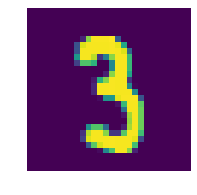

In [130]:
data.train_ds.x[42].show()

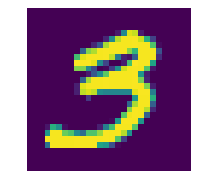

In [131]:
data.valid_ds.x[42].show()

### Design und Training des neuronalen Netzes

Wir erzeugen ein einfaches mehrlagiges Perzeptron (Multilayer Perceptron).

* input layer: 784 (=28x28)
* first hidden layer: 400
* second hidden layer: 64
* output layer: 10

Das Netz wird mit einer eigenen Klasse definiert. Im Konstruktor der Klasse werden die Schichten durch die zu trainierenden Gewichte definiert. Die eigentliche Berechnung wird in der Methode `forward` definiert. Schaue dir die Dokumentation der genutzten Objekte und Funktionen an.

In [161]:
class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(28*28, 400, bias=True) # input -> 1st hidden layer
        self.hidden2 = nn.Linear(400, 64, bias=True) # 1st hidden layer -> 2nd hidden layer
        self.output = nn.Linear(64, 10, bias=True) # 2nd hidden layer -> output layer

    def forward(self, xb):
        x = xb.view(-1, 28*28) # input layer
        x = torch.sigmoid(self.hidden1(x)) # 1st hidden layer after activation
        x = torch.sigmoid(self.hidden2(x)) # 2nd hidden layer after activation
        x = torch.softmax(self.output(x), dim=1) # output layer after activation
        return x

Jetzt können wir unser neu erstelltes Netz trainieren.

In [162]:
learn = Learner(data=data, model=MNIST_MLP(), loss_func=nn.CrossEntropyLoss(), metrics=error_rate)

In [163]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.539417,1.531049,0.063400,00:16
1,1.513461,1.513516,0.049300,00:17


Das Netz scheint nacht dem kurzen Training (2 Epochen) mit den Grundeinstellungen schon sehr gute Ergebnisse zu liefern. Wir könnten das Netz durch einen erneuten Aufruf von `learn.fit_one_cycle(n)` für weitere `n` Epochen trainieren. Falls dabei etwas schief geht (z.B. falls die error_rate plötzlich wieder ansteigt), können wir von Vorne beginnen, in dem wir den Learner einfach neu erstellen. Die Gewichte werden dabei zufällig initialisiert und lassen sich z.B. mit `learn.model.hidden1.weight` anzeigen. 

Schauen wir uns die Konfusionsmatrix nach dem ersten Training an, die eine schöne Diagonale zeigen sollte.

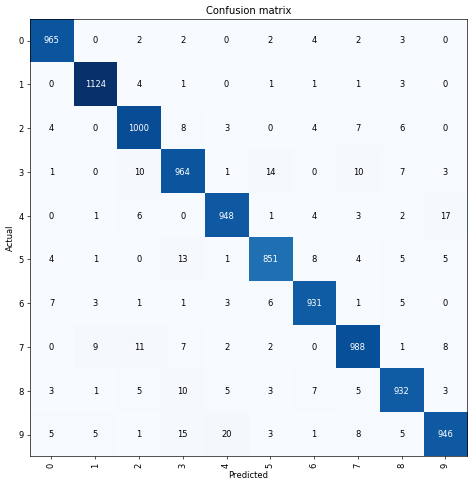

In [70]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

Jetzt können wir uns noch die Beispiele anschauen, die das Netz nicht richtig klassifiziert hat. Gibt es dabei Beispiele die auch als Mensch schwer zu klassfizieren sind? 

Anmerkung: `heatmap=False` weil wir für unser Netz keine "heat map" mit dem Standardverfahren berechnen können, da es eine bestimmte Netzstruktur voraussetzt.

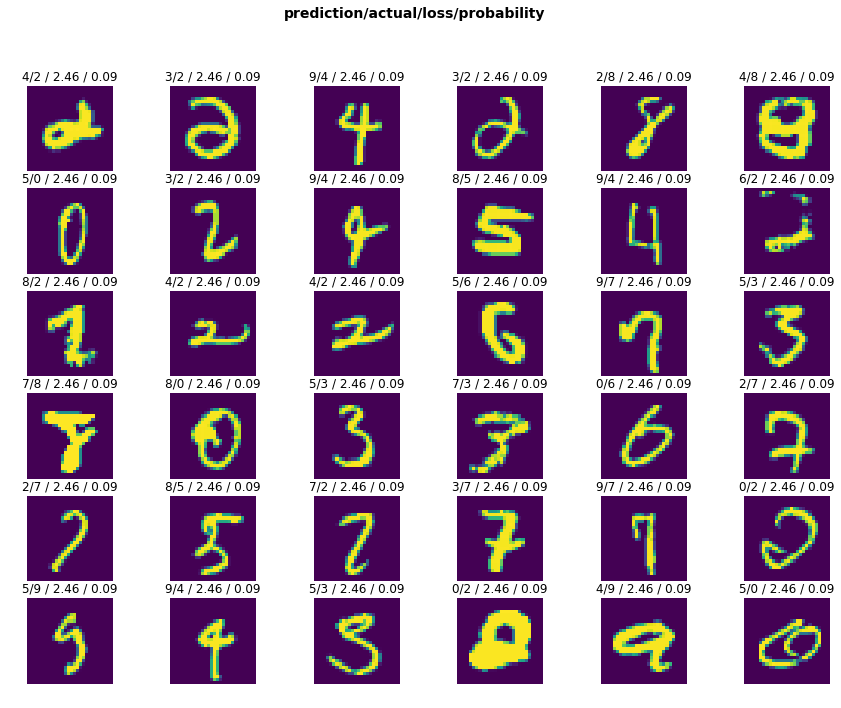

In [63]:
interp.plot_top_losses(36, figsize=(15,11), heatmap=False)

## Aufgaben und Ideen: eigene Bilder

1. Erstelle ein Netz, das Deine Bilder verarbeiten kann. Erstelle dafür eine Kopie des ganzen Notebooks oder kopiere die benötigten Zellen in einen neuen Abschnitt. Achte darauf, dass Du die richtigen Dimensionen wählst. Wenn Du farbige Bilder verarbeiten möchtest, brauchst Du für die Input-Layer einen Vektor der Größe `width * height * 3`. Welche Größe ist für Deine Bilder passend? Eine klassische Größe wäre 224x224 Pixel. Hast Du getrennte Trainings- und Testdaten? Wenn nein, gibt es z.B. auch die Funktion `split_by_rand_pct` um deine Daten zufällig zu splitten.
2. Trainiere das Netz.
3. Wie sind die Ergebnisse? Wie sieht die Konfusionsmatrix aus? Wie hoch wäre die Fehlerrate, wenn Du für die Vorhersage einer Klasse zufällig wählst? Ist die Vorhersage des Netzes wesentlich besser als eine zufällige Vorhersage?
4. Was passiert wenn Du mehr Neuronen in die Schichten konfigurierst?
5. Was passiert wenn Du andere Aktivierungsfunktionen nutzt? (Beispiele: `torch.sigmoid`, `torch.relu`, `torch.tanh`)
6. Was passiert wenn Du noch ein paar Epochen länger trainierst?

## Aufgaben und Ideen: MNIST

Bei Deinen Bildern war es wahrscheinlich nicht so einfach gute Ergebnisse zu erzielen. Kannst Du die Ergebnisse auf dem MNIST-Datensatz verbessern? Schaffst Du eine Fehlerrate von 2% oder vielleicht sogar 1%?